In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Construct a tf.data.Dataset
(ds_train, ds_validation, ds_test), metadata  = tfds.load("tf_flowers", split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True, with_info=True)
print(metadata.splits["train"].num_examples)
num_classes = metadata.features["label"].num_classes
print(num_classes)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.
3670
5


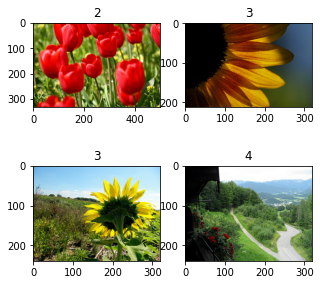

In [3]:
samples = ds_train.take(4)
fig = plt.figure(figsize=(5,5))
for i, ex in enumerate(tfds.as_numpy(samples)):    
    np_image , label =ex
    ax = fig.add_subplot(2,2, i + 1)
    ax.set_title(label)
    ax.imshow(np_image)
plt.show()

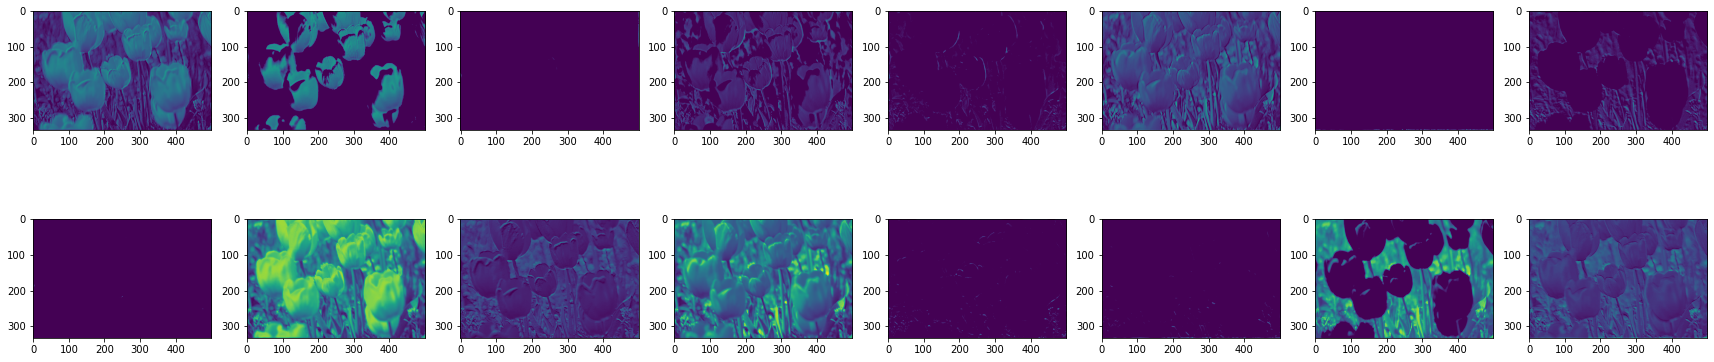

In [4]:
samples = ds_train.take(1)
for i, ex in enumerate(samples):
    image, label = ex
    tf_image = tf.expand_dims(image,0) / 255      
    features_maps = layers.Conv2D(16,3, padding="same", activation="relu")(tf_image)
    fig = plt.figure(figsize=(30,30))
    features_maps = features_maps.numpy().squeeze()
    for i, fmap in enumerate(np.rollaxis(features_maps, -1)):
        ax = fig.add_subplot(8,8, i + 1)        
        ax.imshow(fmap, vmin=np.min(fmap), vmax=np.max(fmap))
    plt.show()

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)
])

AUTOTUNE = tf.data.experimental.AUTOTUNE
def prepare(ds,batch_size=32, shuffle=False, augment=False):
  # Resize and rescale the images
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)
  # create batches
  ds = ds.batch(batch_size)
  
  # apply data augmentation in case that is required
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

resized_train_ds = prepare(ds_train, shuffle=True, augment=True)
resized_val_ds = prepare(ds_validation)
resized_test_ds = prepare(ds_test)

In [6]:
model = Sequential([
  #data_augmentation, 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [7]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.build(input_shape = (None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)       

In [8]:
epochs=40
history = model.fit(resized_train_ds,validation_data=resized_val_ds, epochs=epochs)

Epoch 1/40
      2/Unknown - 0s 35ms/step - loss: 1.6806 - accuracy: 0.1406WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0221s vs `on_train_batch_end` time: 0.0481s). Check your callbacks.


92/92 [==============================] - 22s 244ms/step - loss: 1.2866 - accuracy: 0.4247 - val_loss: 1.0618 - val_accuracy: 0.6022
Epoch 2/40
92/92 [==============================] - 22s 243ms/step - loss: 1.0495 - accuracy: 0.5729 - val_loss: 1.0994 - val_accuracy: 0.5749
Epoch 3/40
92/92 [==============================] - 23s 246ms/step - loss: 0.9844 - accuracy: 0.6127 - val_loss: 0.9758 - val_accuracy: 0.6403
Epoch 4/40
92/92 [==============================] - 22s 242ms/step - loss: 0.9161 - accuracy: 0.6427 - val_loss: 0.9017 - val_accuracy: 0.6594
Epoch 5/40
92/92 [==============================] - 23s 245ms/step - loss: 0.8650 - accuracy: 0.6587 - val_loss: 0.9445 - val_accuracy: 0.6458
Epoch 6/40
92/92 [==============================] - 22s 243ms/step - loss: 0.8288 - accuracy: 0.6829 - val_loss: 0.8365 - val_accuracy: 0.6730
Epoch 7/40
92/92 [==============================] - 23s 245ms/step - loss: 0.7863 - accuracy: 0.6928 - val_loss: 0.8502 - val_accuracy: 0.6839
Epoch 8/40

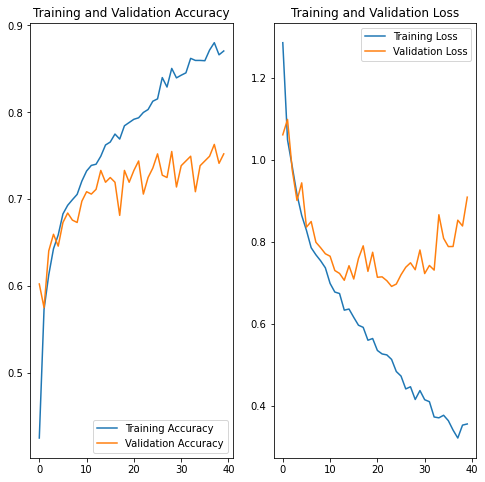

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

INFO:tensorflow:Assets written to: /tmp/model/assets


INFO:tensorflow:Assets written to: /tmp/model/assets


This image most likely belongs to sunflowers with a 100.00 percent confidence.


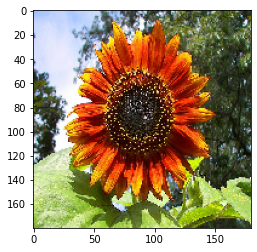

In [11]:
model.save('/tmp/model')
loaded_model = tf.keras.models.load_model('/tmp/model')
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_tensor = tf.expand_dims(img_array, 0) # Create a batch
predictions = loaded_model.predict(img_tensor)
score = tf.nn.softmax(predictions[0])
class_names = metadata.features['label'].names
print( "This image most likely belongs to {} with a {:.2f} percent confidence." .format(class_names[np.argmax(score)], 100 * np.max(score)))
plt.imshow(img_array.astype(np.uint8))
plt.show()